# Conditional GAN
 
 * task: $G$ take a random noise and a label as input and output a digtal number image as output


    eg. give a random noise, and a label 7, then the networl will output a 7 image, when noise change, the shape of output 7 will solwly change too.
 * model we use: MLP in both $G$ and $D$
 * GAN's loss: naive GAN loss

## imports

In [1]:
import torch

from torch import nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader


import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## define model

* $G$: map random noise and label to an image
* $D$: map a image and its label to one scalar

what diffs from naive GAN is that: both G and D must take their origin input plus a label as input.
* D not only disc the real or fake of generated image, but alse check the relationship between input image and label
* if G generates a real-like image but does not accord to label, then D will disc it as fake.

In [23]:
class Discriminator(nn.Module):
    """
    input: (N, img_dim + embed_size)
    output: (N,)
    """
    def __init__(self, num_class=10, embed_size=10, img_dim=28*28):
        super(Discriminator, self).__init__()

        # nn.Embedding: map a num to a vector
        self.label_embed = nn.Embedding(num_class, embed_size)

        self.main = nn.Sequential(
            nn.Linear(embed_size + img_dim, 1024),
            nn.LeakyReLU(0.2, True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img, label):
        label = self.label_embed(label)
        input_ = torch.cat((img, label), dim=1)
        return self.main(input_)

def test_disc():
    model = Discriminator()
    img = torch.randn(8, 28*28)
    label = torch.randint(0, 10, (8,))
    print(f"num params: {sum(p.numel() for p in model.parameters() if p.requires_grad==True)}")
    print(f"input shape: {img.shape}, {label.shape}; output shape: {model(img, label).shape}")
test_disc()

num params: 1470565
input shape: torch.Size([8, 784]), torch.Size([8]); output shape: torch.Size([8, 1])


In [24]:
class Generator(nn.Module):
    """
    input: (N, noise_dim + embed_size)
    output: (N, 1*28*28)
    """
    def __init__(self, noise_dim=100, num_class=10, img_dim=28*28, embed_size=10):
        super(Generator, self).__init__()
        self.label_embed = nn.Embedding(num_class, embed_size)
        self.main = nn.Sequential(
            nn.Linear(embed_size + noise_dim, 256),
            nn.LeakyReLU(0.2, True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, True),
            nn.Linear(1024, img_dim)
        )

    def forward(self, noise, label):
        label = self.label_embed(label)
        input_ = torch.cat((noise, label), dim=1)
        return self.main(input_)

def test_gen():
    model = Generator()
    noise = torch.randn(8, 100)
    label = torch.randint(0, 10, (8,))
    print(f"num params: {sum(p.numel() for p in model.parameters() if p.requires_grad==True)}")
    print(f"input shape: {noise.shape}, {label.shape}; output shape: {model(noise, label).shape}")
test_gen()

num params: 1489012
input shape: torch.Size([8, 100]), torch.Size([8]); output shape: torch.Size([8, 784])


## define params

In [19]:
# learning rate is slightly smaller than common 1e-3
lr = 2e-4
# noise dim
noise_dim = 100
num_class = 10
image_dim= 28*28*1
batch_size = 64
num_epoch = 5

# use fix noise to gen image at sample time
fix_noise = torch.randn(100, noise_dim).to(DEVICE)
fix_labels = torch.tensor([i for i in range(10)] * 10, dtype=torch.int).to(DEVICE)

## prepare data
* way of preprocessing input image: make it in range (0, 1)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()])

dataset = datasets.MNIST(root="./dataset/MNIST", transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

## define optim, loss

In [25]:
disc = Discriminator().to(DEVICE)
gen = Generator().to(DEVICE)

opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)

criterion = nn.BCELoss()

true_label = torch.ones((batch_size,1)).to(DEVICE)
fake_label = torch.zeros((batch_size,1)).to(DEVICE)

In [26]:
!rm -rf ./run
real_writer = SummaryWriter(log_dir="./run/real")
fake_writer = SummaryWriter(log_dir="./run/fake")

## define training loop


  0%|          | 0/937 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:[ 0/ 5], batch[   0/ 937], loss:[0.693841,0.713515]


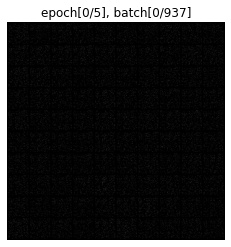

  0%|          | 0/937 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:[ 1/ 5], batch[   0/ 937], loss:[0.337545,2.471298]


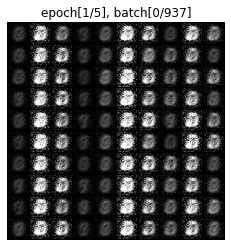

  0%|          | 0/937 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:[ 2/ 5], batch[   0/ 937], loss:[0.476900,1.482244]


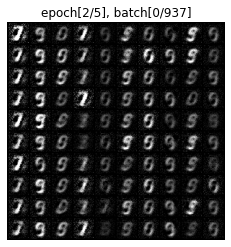

  0%|          | 0/937 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:[ 3/ 5], batch[   0/ 937], loss:[0.253660,1.532756]


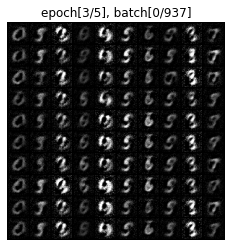

  0%|          | 0/937 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:[ 4/ 5], batch[   0/ 937], loss:[0.506696,1.767548]


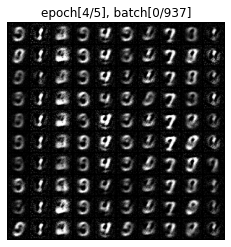

  0%|          | 0/937 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:[ 5/ 5], batch[   0/ 937], loss:[0.397459,1.711386]


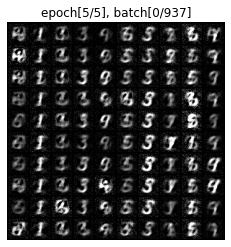

  0%|          | 0/937 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:[ 6/ 5], batch[   0/ 937], loss:[0.432166,1.821487]


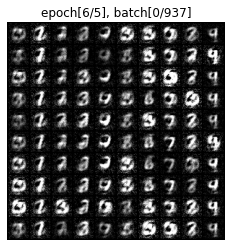

  0%|          | 0/937 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:[ 7/ 5], batch[   0/ 937], loss:[0.318130,2.137542]


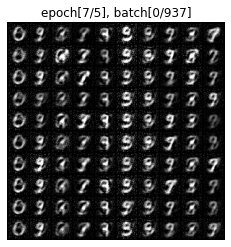

  0%|          | 0/937 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:[ 8/ 5], batch[   0/ 937], loss:[0.391375,1.300536]


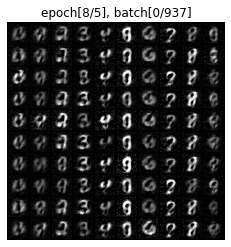

  0%|          | 0/937 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch:[ 9/ 5], batch[   0/ 937], loss:[0.419025,1.328052]


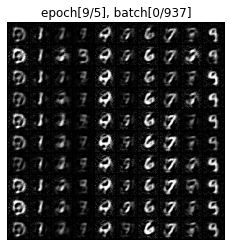

KeyboardInterrupt: ignored

In [27]:
for epoch in range(100):
    loop = tqdm(dataloader, leave=False)
    for batch_idx, (x, y) in enumerate(loop):
        gen.train()

        x = x.view(-1, 784).to(DEVICE)
        y = y.to(DEVICE)

        # disc the real image
        real_disc = disc(x, y)

        # put random noise into generator to gen image
        noise = torch.randn((batch_size, noise_dim)).to(DEVICE)
        fake_out = gen(noise, y)
        # disc the fake image
        fake_disc = disc(fake_out, y)

        # the Discriminator wanna disc real image as real, and fake image as fake.
        # so it assign ones to real, and zeros to fake
        D_loss_1 = criterion(real_disc, torch.ones_like(real_disc))
        D_loss_2 = criterion(fake_disc, torch.zeros_like(fake_disc))
        D_loss=(D_loss_1 + D_loss_2) / 2

        disc.zero_grad()
        D_loss.backward()
        opt_disc.step()

        # the Generator wanna image it generated as real as possible,
        # so it assign ones to fake
        fake_out = gen(noise, y)
        fake_disc = disc(fake_out, y)
        G_Loss = criterion(fake_disc, torch.ones_like(fake_disc))
        gen.zero_grad()
        G_Loss.backward()
        opt_gen.step()
        if batch_idx == 0 :
          print(f"epoch:[{epoch:>2d}/{num_epoch:>2d}], batch[{batch_idx:>4d}/{len(dataloader):>4d}], loss:[{D_loss:>6f},{G_Loss:6f}]")
          with torch.no_grad():
              gen.eval()

              fake_out = gen(fix_noise, fix_labels)
              fake_out = fake_out.reshape(-1, 1, 28, 28)

              real = x.view(-1, 1, 28, 28)[:36]

              img_grid_fake = torchvision.utils.make_grid(fake_out, nrow=10)
              plt.imshow(img_grid_fake.cpu().permute(1,2,0).numpy())
              plt.title(f"epoch[{epoch}/{num_epoch}], batch[{batch_idx}/{len(dataloader)}]")
              plt.axis("off")
              plt.show()
              img_grid_true = torchvision.utils.make_grid(real, nrow=6)

              real_writer.add_image(tag="real", img_tensor=img_grid_true, global_step=epoch)
              fake_writer.add_image(tag="fake", img_tensor=img_grid_fake, global_step=epoch)

